# Setup

In this notebook, we perform a Difference-in-Differences (DiD) analysis to examine the impact of the 1993 expansion of the Earned Income Tax Credit (EITC) on the employment probabilities of mothers in the United States. The EITC is a refundable tax credit aimed at low- to moderate-income working individuals and families, particularly those with children.

The 1993 expansion significantly increased the benefits for families with children, which may have influenced mothers' decisions to participate in the labor force.

We utilize logistic regression models to estimate the probability of employment, comparing mothers (treatment group) to non-mothers (control group) before and after the policy change.

Additionally, we conduct a placebo experiment to test the validity of our findings by checking for pre-existing trends before the policy implementation.

First, we set up the environment by mounting Google Drive to access the data stored there.



In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory to the specific path where the data is stored
%cd /content/drive/MyDrive/Statistics and Econometrics/Econometrics/Difference-in-Differences

/content/drive/MyDrive/Statistics and Econometrics/Econometrics/Difference-in-Differences


We import the necessary libraries for data manipulation, statistical analysis, and visualization.


In [ ]:
# Import essential libraries
import pandas as pd                  # For data manipulation and analysis
import numpy as np                   # For numerical computations
import matplotlib.pyplot as plt      # For plotting graphs
import statsmodels.api as sm         # For statistical modeling and regression analysis

We load the dataset and preview its structure to understand the available variables and their formats.


In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_stata("eitc.dta")

# Display the first five rows of the dataset
df.head()

,state,year,urate,children,nonwhite,finc,earn,age,ed,work,unearn
0,11.0,1991.0,7.6,0,1,18714.394273,18714.394273,26,10,1,0.000000
1,12.0,1991.0,7.2,1,0,4838.568282,471.365639,22,9,1,4.367203
2,13.0,1991.0,6.4,2,0,8178.193833,0.000000,33,11,0,8.178194
3,14.0,1991.0,9.1,0,1,9369.570485,0.000000,43,11,0,9.369570
4,15.0,1991.0,8.6,3,1,14706.607930,14706.607930,23,7,1,0.000000


The dataset contains individual-level data with variables such as:

* `year`: The year of observation
* `children`: Number of children
* `work`: Employment status (1 if working, 0 otherwise)
* Other demographic variables

We check the unique years present in the dataset to understand the time frame of our analysis.

In [ ]:
df.year.unique()

array([1991., 1992., 1993., 1994., 1995., 1996.], dtype=float32)

# Data Processing

We create dummy variables to indicate whether an individual is a mother (`mom`), whether the observation is after the policy change in 1993 (`post_93`), and an interaction term (`mom_post_93`) for the Difference-in-Differences analysis.


In [ ]:
# Create a dummy variable 'mom' where 1 indicates the individual has children, and 0 otherwise
df['mom'] = np.where(df['children'] > 0, 1, 0)

# Create a dummy variable 'post_93' where 1 indicates the year is after 1993, and 0 otherwise
df['post_93'] = np.where(df['year'] > 1993, 1, 0)

# Create an interaction term 'mom_post_93' for mothers after 1993
df['mom_post_93'] = df['mom'] * df['post_93']

# Preview the updated DataFrame
df.head()


,state,year,urate,children,nonwhite,finc,earn,age,ed,work,unearn,mom,post_93,mom_post_93
0,11.0,1991.0,7.6,0,1,18714.394273,18714.394273,26,10,1,0.000000,0,0,0
1,12.0,1991.0,7.2,1,0,4838.568282,471.365639,22,9,1,4.367203,1,0,0
2,13.0,1991.0,6.4,2,0,8178.193833,0.000000,33,11,0,8.178194,1,0,0
3,14.0,1991.0,9.1,0,1,9369.570485,0.000000,43,11,0,9.369570,0,0,0
4,15.0,1991.0,8.6,3,1,14706.607930,14706.607930,23,7,1,0.000000,1,0,0


Explanation of Key Concepts:

* **Dummy Variables**: Binary variables (0 or 1) used to represent categorical data in regression models.
* **Interaction Term**: Used in regression models to capture the effect of two variables interacting with each other, essential in Difference-in-Differences analysis.

We prepare our dependent and independent variables for the regression analysis.

In [ ]:
# Define the dependent variable 'y' as the employment status
y = df['work']

# Define the independent variables for the model
X = df[['mom', 'post_93', 'mom_post_93']]

# Preview the independent variables
X.head()

,mom,post_93,mom_post_93
0,0,0,0
1,1,0,0
2,1,0,0
3,0,0,0
4,1,0,0


# Logistic Regression Model

We add a constant term to include an intercept in the logistic regression model.


In [ ]:
# Add a constant term to the independent variables
X = sm.add_constant(X)

We fit a logistic regression model to estimate the probability of employment.

Explanation of Key Concepts:

* **Logistic Regression**: A statistical model used for binary classification, estimating the probability that a given input point belongs to a certain category.
* **Logit Function**: The link function used in logistic regression, relating the linear combination of predictors to the log-odds of the outcome.

In [ ]:
# Fit the logistic regression model using the Logit function
model1 = sm.Logit(y, X).fit()

# Print the summary of the model with descriptive variable names
print(model1.summary(
    yname="Is Working?",
    xname=['Intercept', "Is Mom", "Is after 1993", "Mom after 1993"]
))

Optimization terminated successfully.
         Current function value: 0.686491
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            Is Working?   No. Observations:                13746
Model:                          Logit   Df Residuals:                    13742
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                0.009118
Time:                        14:23:15   Log-Likelihood:                -9436.5
converged:                       True   LL-Null:                       -9523.3
Covariance Type:            nonrobust   LLR p-value:                 2.058e-37
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3042      0.036      8.443      0.000       0.234       0.375
Is mom  

We define a helper function to convert log-odds from the logistic regression model into probabilities.

In [ ]:
# Define a function to convert log-odds to probabilities
def logit_to_prob(log_odds):
    return 1 / (1 + np.exp(-log_odds))

# Example usage: Convert a log-odds value to probability
logit_to_prob(0.19)

0.5473576181430894

## Data Visualization

We visualize the results of our Difference-in-Differences analysis to interpret the impact of the EITC expansion.

We extract the estimated coefficients from the logistic regression model.

In [ ]:
# Extract the coefficients from the logistic regression model
intercept_coef, mom_coef, post93_coef, mom_post93_coef = model1.params

Using the coefficients, we compute the predicted probabilities of employment for each group.

In [ ]:
# Compute predicted probabilities for non-mothers before and after 1993
non_mom_pre = logit_to_prob(intercept_coef)
non_mom_post = logit_to_prob(intercept_coef + post93_coef)

# Compute predicted probabilities for mothers before and after 1993
mom_pre = logit_to_prob(intercept_coef + mom_coef)
mom_post = logit_to_prob(intercept_coef + mom_coef + post93_coef + mom_post93_coef)

# Compute the counterfactual probability for mothers after 1993 if there was no treatment effect
counterfactual = logit_to_prob(intercept_coef + mom_coef + post93_coef)


We plot the predicted probabilities to visualize the impact of the EITC expansion.

[]

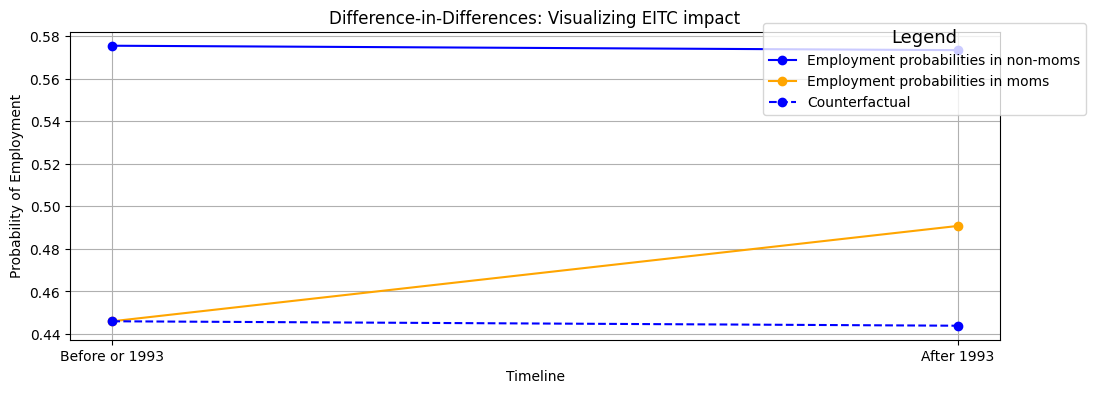

In [ ]:
# Settting the figure
plt.figure(figsize=(12, 4))
timeline = ['Before or 1993', 'After 1993']

# Plotting of the comparison
plt.plot(timeline,
         [non_mom_pre, non_mom_post],
         label = "Employment probabilities in non-moms",
         marker = "o",
         color = "blue")
plt.plot(timeline,
         [mom_pre, mom_post],
         label = "Employment probabilities in moms",
         marker = "o",
         color = "orange")
plt.plot(timeline,
         [mom_pre, counterfactual],
         label = "Counterfactual",
         marker = "o",
         color = "blue",
         linestyle = "--")

# Customizing the plot
plt.title("Difference-in-Differences: Visualizing EITC impact")
plt.xlabel("Timeline")
plt.ylabel("Probability of Employment")
plt.legend(loc = "upper right", title = "Legend", fontsize = 10,
           title_fontsize = 13, bbox_to_anchor = (1.1, 1.05))
plt.grid(True)

plt.plot()

Explanation of Key Concepts:

**Difference-in-Differences (DiD)**: A quasi-experimental design used to estimate causal relationships by comparing the changes in outcomes over time between a group that is exposed to a treatment and a group that is not.

# Second Model

We extend our model by including additional control variables to account for other factors that might affect employment.

In [ ]:
# Preview the variables
df.columns

Index(['state', 'year', 'urate', 'children', 'nonwhite', 'finc', 'earn', 'age',
       'ed', 'work', 'unearn', 'mom', 'post_93', 'mom_post_93'],
      dtype='object')

We include education level (`ed`), age (`age`), and unearned income (`unearn`) in the model.

In [ ]:
# Select additional independent variables
X2 = df[['mom', 'post_93', 'mom_post_93', 'ed', 'age', 'unearn']]

# Add a constant term to the independent variables
X2 = sm.add_constant(X2)

**Control Variables**: Variables included in a regression model to account for other factors that might influence the dependent variable, improving the model's accuracy.

In [ ]:
# Fit the logistic regression model with additional variables
model2 = sm.Logit(y, X2).fit()

# Print the summary of the new model
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.638107
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   work   No. Observations:                13746
Model:                          Logit   Df Residuals:                    13739
Method:                           MLE   Df Model:                            6
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                 0.07896
Time:                        15:57:43   Log-Likelihood:                -8771.4
converged:                       True   LL-Null:                       -9523.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3483      0.109     -3.196      0.001      -0.562      -0.135
mom            -0.4733    

# Placebo Experiment

To test the robustness of our results, we perform a placebo experiment by simulating the policy change in a period before it actually happened.

We create a subset of the data that includes only observations up to 1993.

In [ ]:
# Create a subset of the data including only years up to 1993
df_placebo = df[df['year'] <= 1993].copy()

We create placebo variables simulating a policy change in 1992.

In [ ]:
# Create a placebo 'post_92' variable where 1 indicates the year is after 1992, and 0 otherwise
df_placebo['post_92'] = np.where(df_placebo['year'] > 1992, 1, 0)

# Create a placebo interaction term 'mom_post_92' for mothers after 1992
df_placebo['mom_post_92'] = df_placebo['mom'] * df_placebo['post_92']

We prepare the dependent and independent variables for the placebo regression.

In [ ]:
# Define the dependent variable 'y' for the placebo model
y_placebo = df_placebo['work']

# Define the independent variables for the placebo model
X_placebo = df_placebo[['mom', 'post_92', 'mom_post_92']]

In [ ]:
# Add a constant term to the independent variables
X_placebo = sm.add_constant(X_placebo)

We fit the placebo logistic regression model.

In [ ]:
# Fit the logistic regression model for the placebo experiment
model_placebo = sm.Logit(y_placebo, X_placebo).fit()

# Print the summary of the placebo model
print(model_placebo.summary())


Optimization terminated successfully.
         Current function value: 0.684872
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   work   No. Observations:                 7401
Model:                          Logit   Df Residuals:                     7397
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                 0.01193
Time:                        16:13:13   Log-Likelihood:                -5068.7
converged:                       True   LL-Null:                       -5130.0
Covariance Type:            nonrobust   LLR p-value:                 2.290e-26
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3124      0.044      7.154      0.000       0.227       0.398
mom            -0.5138    

## Data Visualization for the Placebo Experiment

We visualize the results of the placebo experiment to check for any pre-existing trends.

We extract the estimated coefficients from the placebo model.

In [ ]:
# Extract the coefficients from the placebo logistic regression model
intercept_coef, mom_coef, post92_coef, mom_post92_coef = model_placebo.params

Using the coefficients, we compute the predicted probabilities for the placebo experiment.

In [ ]:
# Compute predicted probabilities for non-mothers before and after 1992
non_mom_pre = logit_to_prob(intercept_coef)
non_mom_post = logit_to_prob(intercept_coef + post92_coef)

# Compute predicted probabilities for mothers before and after 1992
mom_pre = logit_to_prob(intercept_coef + mom_coef)
mom_post = logit_to_prob(intercept_coef + mom_coef + post92_coef + mom_post92_coef)

# Compute the placebo counterfactual for mothers
placebo_counterfactual = logit_to_prob(intercept_coef + mom_coef + post92_coef)

We plot the predicted probabilities to visualize the results of the placebo experiment.

[]

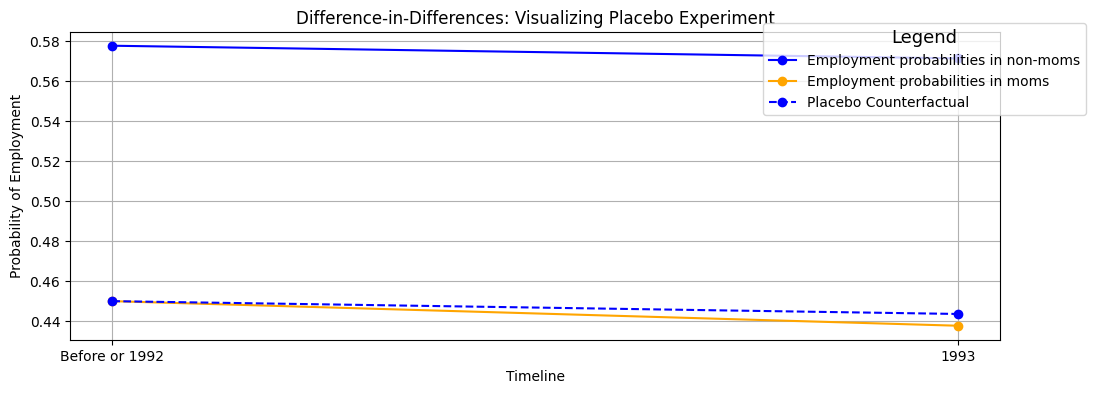

In [ ]:
# Set the size of the plot
plt.figure(figsize=(12, 4))

# Define the timeline labels for the placebo experiment
timeline = ['Before or 1992', '1993']

# Plot employment probabilities for non-mothers
plt.plot(timeline,
         [non_mom_pre, non_mom_post],
         label="Employment probabilities for non-mothers",
         marker="o",
         color="blue")

# Plot employment probabilities for mothers
plt.plot(timeline,
         [mom_pre, mom_post],
         label="Employment probabilities for mothers",
         marker="o",
         color="orange")

# Plot the placebo counterfactual for mothers
plt.plot(timeline,
         [mom_pre, placebo_counterfactual],
         label="Placebo Counterfactual for mothers",
         marker="o",
         color="green",
         linestyle="--")

# Customize the plot
plt.title("Difference-in-Differences: Visualizing Placebo Experiment")
plt.xlabel("Timeline")
plt.ylabel("Probability of Employment")
plt.legend(loc="upper right", title="Legend", fontsize=10, title_fontsize=13)
plt.grid(True)

# Display the plot
plt.show()

# Conclusion

Our analysis suggests that the 1993 expansion of the EITC had a positive impact on the employment probabilities of mothers relative to non-mothers, as indicated by the significant coefficient of the interaction term in the logistic regression model. The Difference-in-Differences approach allows us to control for common trends affecting both groups over time.

The inclusion of additional control variables in the second model strengthens the robustness of our findings by accounting for other factors that may influence employment. Furthermore, the placebo experiment shows no significant effect in the pre-policy period, supporting the validity of the parallel trends assumption inherent in the DiD methodology.

These results highlight the effectiveness of the EITC policy in encouraging labor force participation among mothers, which has important implications for policymakers aiming to design programs that promote employment among targeted groups.